In [2]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
import glob


def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-18 02:16:22.228037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 02:16:22.436514: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 02:16:22.477327: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 02:16:25.268200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #0


## 1. Preparing Dataset PBMC

In [3]:


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected




In [4]:
data_dir = "./"

In [5]:
mdata = mu.read_10x_mtx(os.path.join(data_dir, "filtered_feature_bc_matrix"))

In [6]:
mdata_raw = mu.read_10x_mtx(os.path.join(data_dir, "raw_feature_bc_matrix"))

## Protein

In [7]:
prot = mdata.mod['prot']
prot

AnnData object with n_obs × n_vars = 5247 × 32
    var: 'gene_ids', 'feature_types'

#### DSB normalisation

In [8]:
#pt.pp.dsb(mdata, raw=mdata_raw, empty_droplets=droplets)

In [9]:
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)

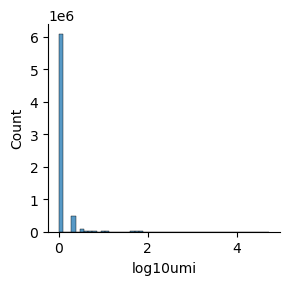

In [10]:
mu.pl.histogram(mdata_raw['rna'], ['log10umi'], bins=50)

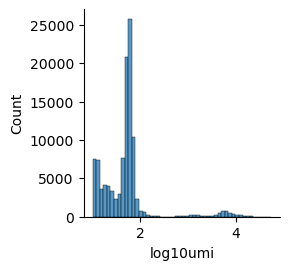

In [11]:
mu.pl.histogram(mdata_raw['rna'][mdata_raw['rna'].obs.log10umi >= 1], ['log10umi'], bins=50)

In [12]:
isotypes = mdata_raw['prot'].var_names[29:32].values
isotypes

array(['IgG1_control_TotalSeqB', 'IgG2a_control_TotalSeqB',
       'IgG2b_control_TotalSeqB'], dtype=object)

In [13]:
prot.layers['counts'] = prot.X

In [14]:
pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.8), isotype_controls=isotypes, random_state=1)

/tmp/ipykernel_2326472/1734432744.py:1: DeprecationWarning: empty_counts_range will be deprecated in the future versions
  pt.pp.dsb(mdata, mdata_raw, empty_counts_range=(1.5, 2.8), isotype_controls=isotypes, random_state=1)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/muon/_prot/preproc.py:137: UserWarning: Dropping 49 empty droplets as they are already defined as cells
  warn(


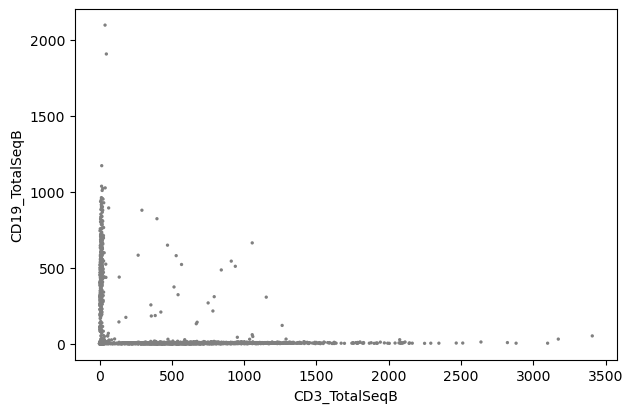

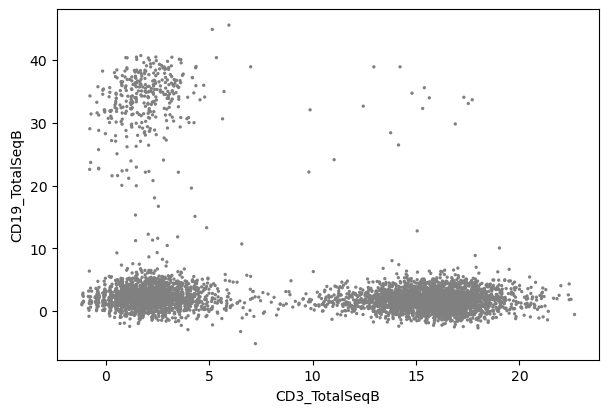

In [15]:
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB", layers='counts')
sc.pl.scatter(mdata['prot'], x="CD3_TotalSeqB", y="CD19_TotalSeqB")

#### Downstream analysis

In [16]:
sc.tl.pca(prot)

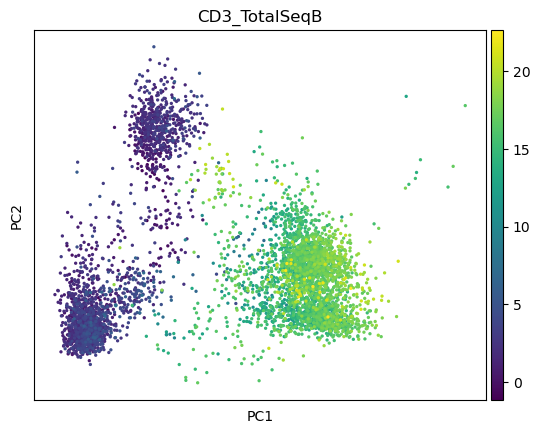

In [17]:
sc.pl.pca(prot, color='CD3_TotalSeqB')

In [18]:
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

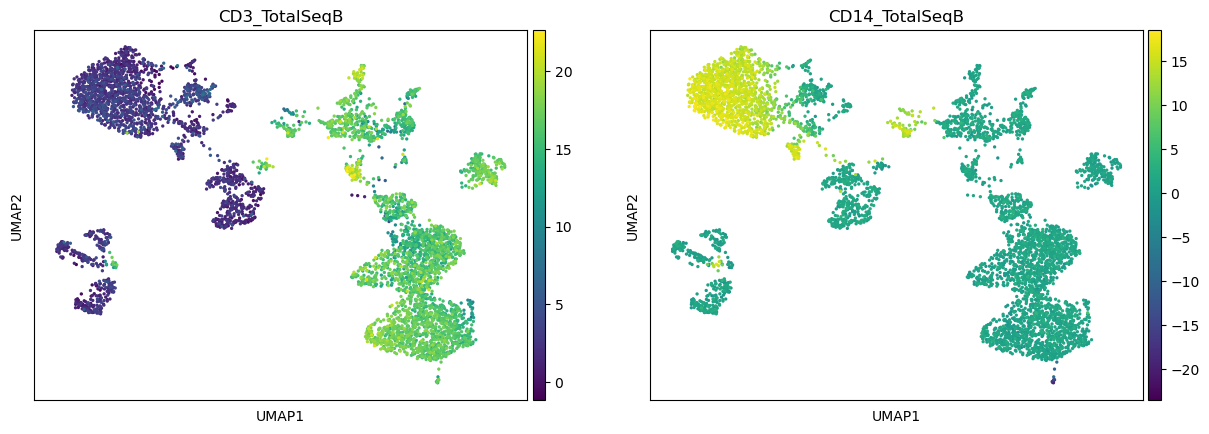

In [19]:
sc.pl.umap(prot, color=['CD3_TotalSeqB', 'CD14_TotalSeqB'])

## RNA

In [20]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 5247 × 33538
    var: 'gene_ids', 'feature_types'

#### QC

In [21]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

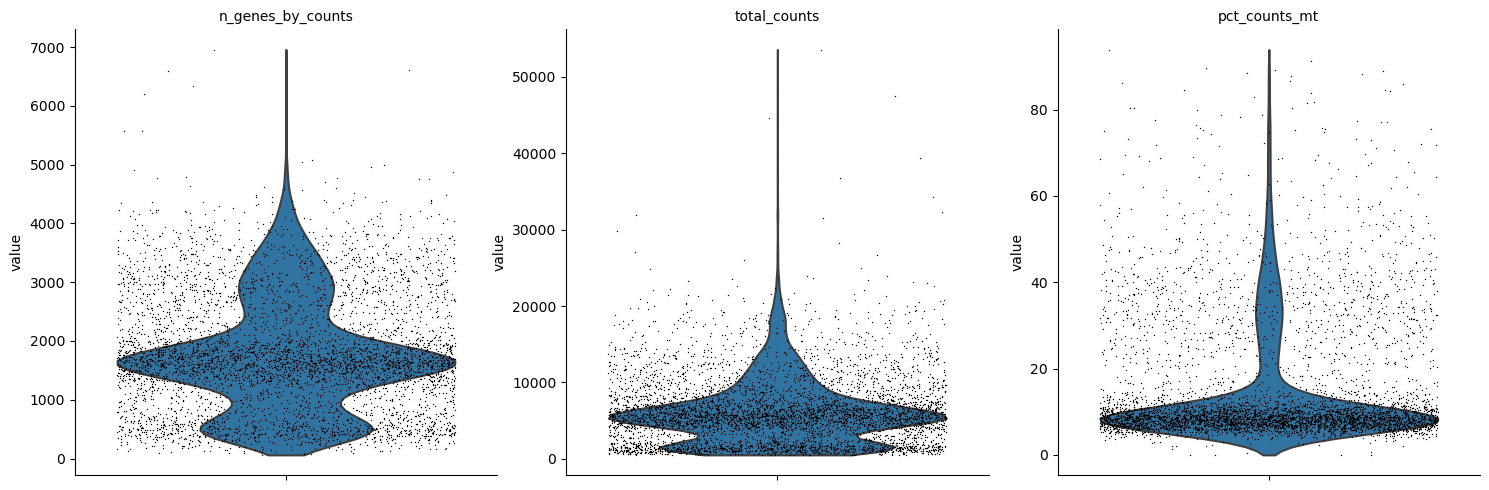

In [22]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [23]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# Same as the following but doesn't copy the object:
#   sc.pp.filter_genes(rna, min_cells=3)

In [24]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# Same as the following but doesn't copy the object
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]

mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

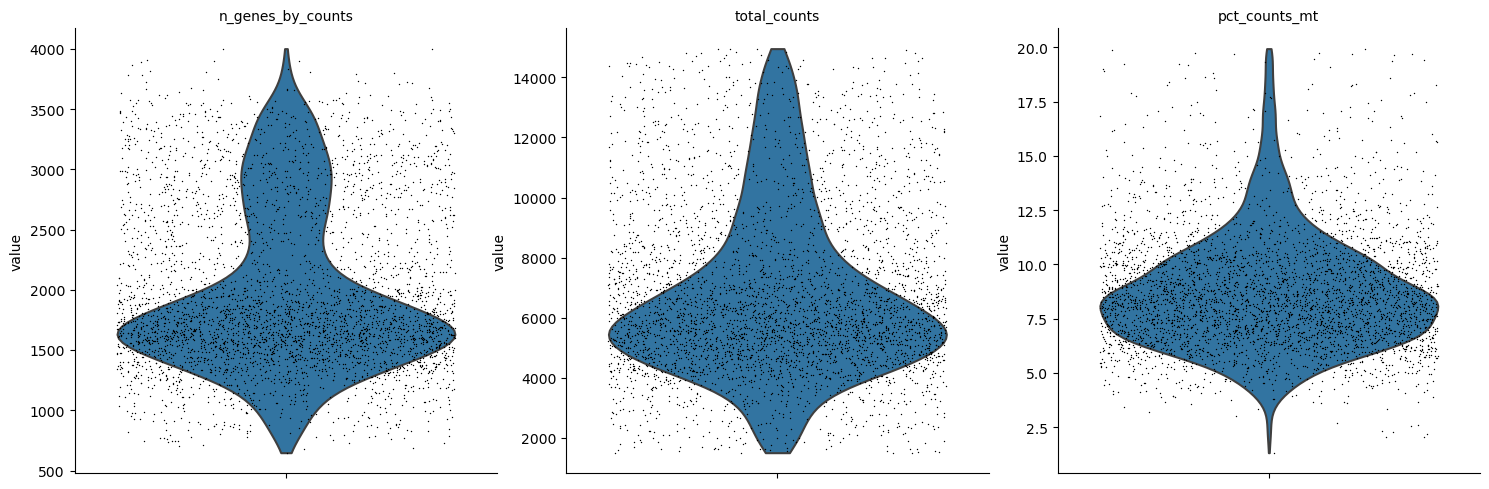

In [25]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [26]:
rna.X.shape

(3891, 17806)

#### Normalisation

In [27]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [28]:
sc.pp.log1p(rna)

#### Feature selection

In [29]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

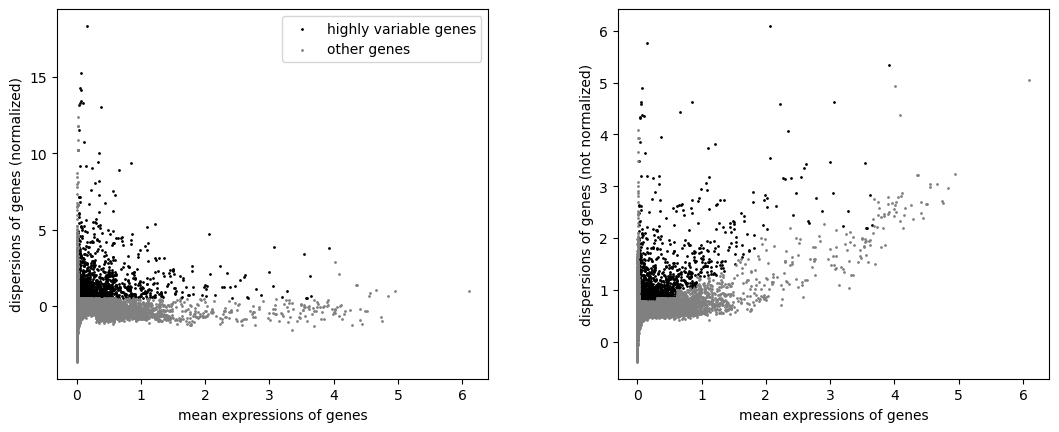

In [30]:
sc.pl.highly_variable_genes(rna)

In [31]:
np.sum(rna.var.highly_variable)

1734

#### Scaling

In [32]:
rna.raw = rna

In [33]:
sc.pp.scale(rna, max_value=10)

#### Analysis

#### PCA and neighbourhood graph

In [34]:
sc.tl.pca(rna, svd_solver='arpack')

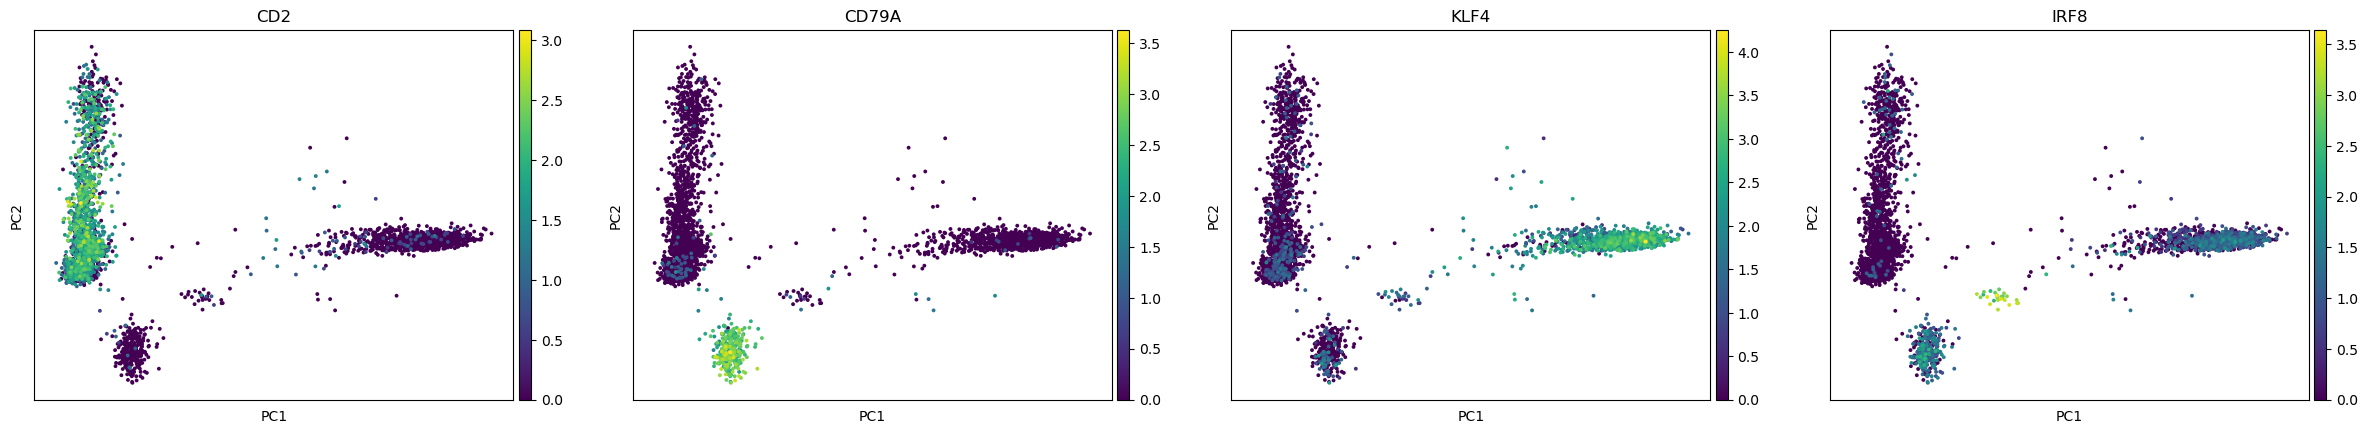

In [35]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

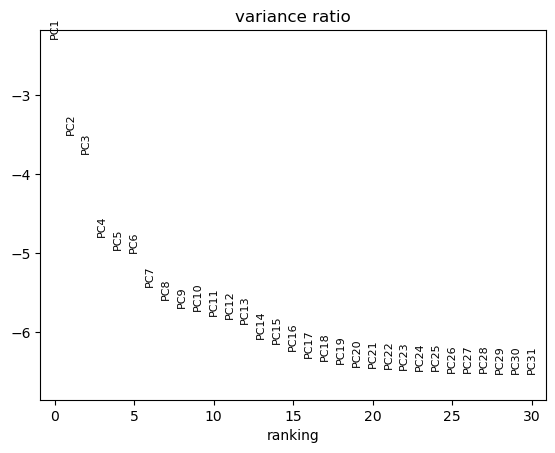

In [36]:
sc.pl.pca_variance_ratio(rna, log=True)

In [37]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

#### Non-linear dimensionality reduction and clustering

In [55]:
sc.tl.leiden(rna, resolution=.75)

In [56]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


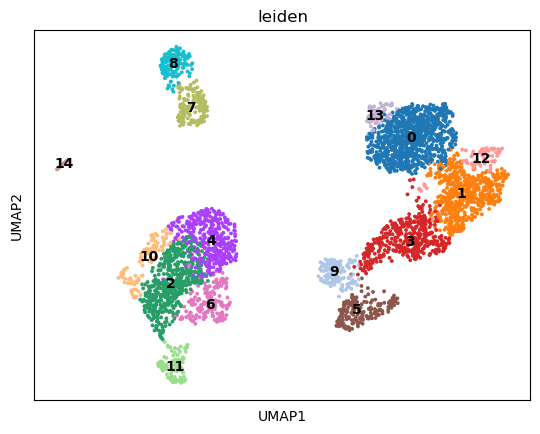

In [57]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

#### Cell type annotation

In [58]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test_overestim_var')

In [59]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,RPL32,3.131031e-247,IL7R,2.072349e-181,CPVL,2.090833e-216,CCL5,2.142454e-191,S100A8,1.099586e-197,GNLY,1.868870e-151,TYMP,1.669195e-56,CD79A,6.409674e-113,IGHM,8.464771e-143,GNLY,1.043864e-91,LYZ,1.037437e-26,FCGR3A,7.931314e-73,IL32,1.369603e-10,CD8B,3.271676e-27,ITM2C,1.106098e-36
1,RPS3A,3.768505e-255,LTB,3.147525e-107,LYZ,7.927088e-163,NKG7,2.266048e-139,S100A9,3.211209e-173,NKG7,5.122290e-96,LYZ,1.977458e-45,MS4A1,1.513867e-103,CD79A,1.148653e-124,FGFBP2,5.357915e-103,CST3,3.256277e-28,LST1,3.169949e-44,PBXIP1,9.267144e-10,CD8A,5.845534e-20,CCDC50,3.365546e-34
2,RPL30,8.925251e-237,IL32,2.144206e-101,FCN1,1.085726e-168,GZMA,4.974245e-104,S100A12,1.794553e-211,KLRD1,4.177881e-111,FCN1,6.962014e-46,HLA-DQA1,3.751461e-106,CD79B,7.831206e-107,GZMH,3.670524e-97,MNDA,2.675983e-22,TCF7L2,1.098160e-45,TRBC2,3.106776e-08,RPS3A,3.719940e-13,IL3RA,2.391787e-23
3,RPL13,3.270407e-226,TRAC,6.722925e-80,CST3,1.504488e-163,CST7,6.332911e-104,VCAN,8.012398e-180,KLRF1,2.123804e-102,MNDA,1.018450e-47,BANK1,1.331708e-84,IGHD,2.549207e-71,KLRC2,6.927268e-76,AIF1,1.930291e-19,SMIM25,3.171770e-49,TTN,2.117105e-07,LINC02446,1.047810e-12,PLD4,1.246056e-27
4,RPL11,9.955405e-232,CD2,1.115379e-62,PSAP,9.054735e-156,IL32,4.254180e-89,MNDA,2.275099e-153,PRF1,1.035348e-103,CTSS,2.797586e-43,CD79B,7.403564e-79,MS4A1,2.422110e-88,PRF1,5.305382e-91,GRN,6.122902e-20,LYN,1.090890e-46,DUSP4,3.266518e-07,RPS2,1.116967e-12,IRF8,2.272772e-29
5,RPS12,4.331656e-222,AQP3,3.628837e-55,CTSS,2.105607e-152,GZMM,1.241104e-82,LYZ,5.746573e-134,CTSW,2.070523e-100,CST3,2.437639e-43,HLA-DQB1,6.762213e-69,HLA-DQA1,1.228020e-87,CST7,1.648846e-81,S100A9,1.087349e-19,MS4A7,6.730315e-51,TRAC,6.454933e-07,RPS6,1.353405e-12,TCF4,2.379939e-28
6,RPS6,5.303758e-226,CD3E,2.596749e-51,FGL2,8.779700e-174,KLRG1,3.640630e-74,FCN1,4.126065e-134,GZMA,8.167417e-91,FGL2,3.035854e-48,CD37,1.360554e-57,TCL1A,1.705306e-64,NKG7,1.857698e-69,FCN1,3.810407e-19,CDKN1C,2.347010e-39,IKZF2,2.514105e-06,RPL13,1.995249e-12,UGCG,2.010952e-26
7,RPL9,5.292022e-226,KLRB1,1.347555e-50,AIF1,3.138062e-155,CD3D,9.415908e-74,CD14,2.493217e-139,GZMB,2.485554e-88,S100A9,2.355759e-44,RALGPS2,1.241453e-54,CD37,8.820436e-66,GZMB,1.958532e-90,CD74,2.626793e-19,FCER1G,4.274696e-38,CD2,1.595230e-06,RPS12,2.544850e-12,IRF7,3.697921e-27
8,TPT1,1.161942e-226,RPS18,9.397442e-49,MNDA,5.282588e-149,B2M,1.811779e-69,CSF3R,2.884765e-142,CLIC3,3.298338e-75,PSAP,1.707314e-42,HLA-DPB1,4.220414e-51,HLA-DPB1,6.584160e-47,CCL5,7.527027e-64,COTL1,8.114751e-18,LRRC25,3.008411e-45,IL2RA,3.732272e-06,RPL32,5.278270e-12,JCHAIN,2.922103e-22
9,RPL34,1.248503e-217,RPL14,1.186353e-47,SERPINA1,1.568069e-162,GZMK,4.080528e-54,CTSD,1.390578e-131,HOPX,2.743328e-83,CD14,1.436607e-49,HLA-DRA,2.174338e-45,CD74,4.442138e-43,FCGR3A,8.307889e-76,TYROBP,2.630031e-17,CFD,5.047006e-41,ISG20,4.100570e-06,RPS5,1.223623e-11,MZB1,4.527073e-20


In [60]:
new_cluster_names = {
    "0": "CD4+ naïve T", "12": "Treg", "2": "intermediate mono",
    "11": "CD16 mono", "4": "CD14 mono",
    "5": "NK", "8": "pre-B",
    "6": "intermediate mono", "7": "mature B",
    "1": "CD4+ memory T", "3": "CD8+ memory T", "9": "memory-like NK", "10": "intermediate mono",
    "13": "CD8+ naïve T", "14":"pDC"
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.replace(new_cluster_names)
rna.obs.celltype = rna.obs.celltype.astype("category")

In [61]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'Treg',
    'CD8+ naïve T', 'CD8+ memory T', 'NK', 'memory-like NK',
    'pre-B', 'mature B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'pDC'], inplace=True)

mdata.update()

/tmp/ipykernel_1010450/4072724542.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  rna.obs.celltype.cat.reorder_categories([
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` 

In [62]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


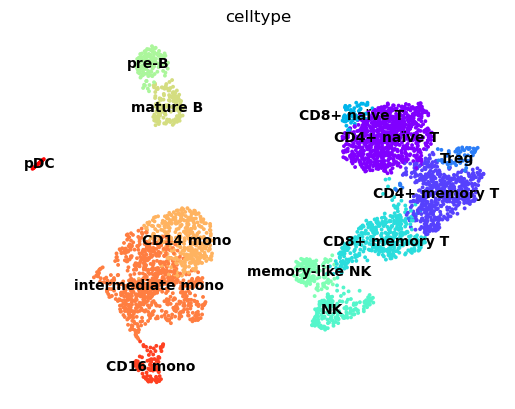

In [63]:
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


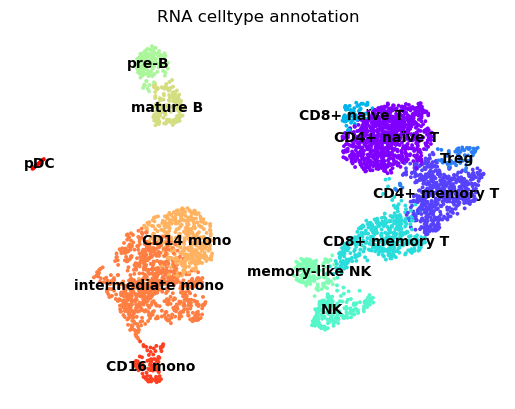

In [64]:
sc.pl.umap(rna, color="celltype", legend_loc="on data", frameon=False,
          title="RNA celltype annotation")

In [65]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'FOXP3', 'IL2RA',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7', 'KLRC2',
                'CD79A', 'MS4A1', 'TCL1A', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'IRF8', 'TCF4']

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


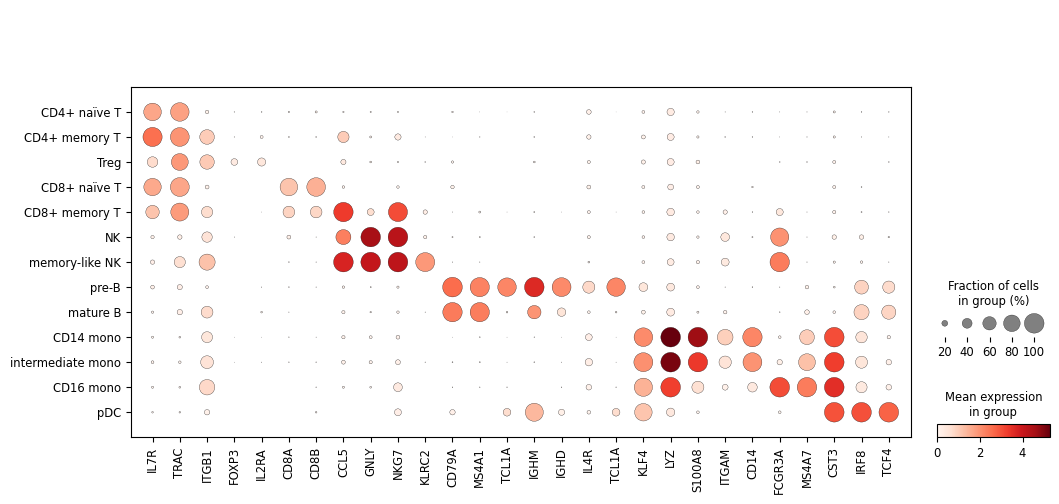

In [66]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

#### Plotting

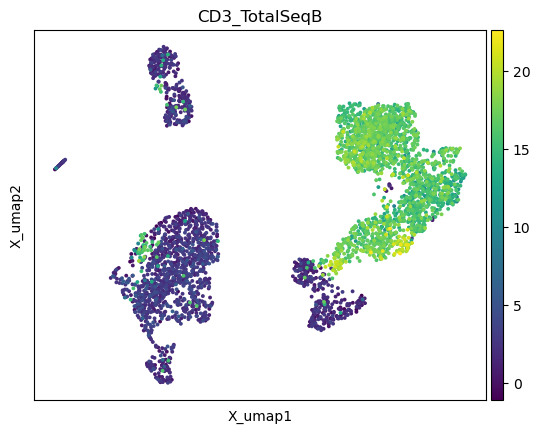

In [67]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3_TotalSeqB"])

In [112]:
mdata.write("pbmc5k_citeseq.h5mu")